In [26]:
import pandas as pd

# CSV 파일 읽기
df_energy = pd.read_csv('한국남동발전_시간대별_풍력_발전실적_최종.csv')
df_energy.head()

,발전구분,호기,일자,시간,발전량(kWh),설비용량(MW),연식(년)
0,삼천포풍력,1,2025-05-31,1,0.000,0.75,7.1
1,삼천포풍력,1,2025-05-31,2,0.000,0.75,7.1
2,삼천포풍력,1,2025-05-31,3,1.008,0.75,7.1
3,삼천포풍력,1,2025-05-31,4,0.000,0.75,7.1
4,삼천포풍력,1,2025-05-31,5,0.000,0.75,7.1


### EDA

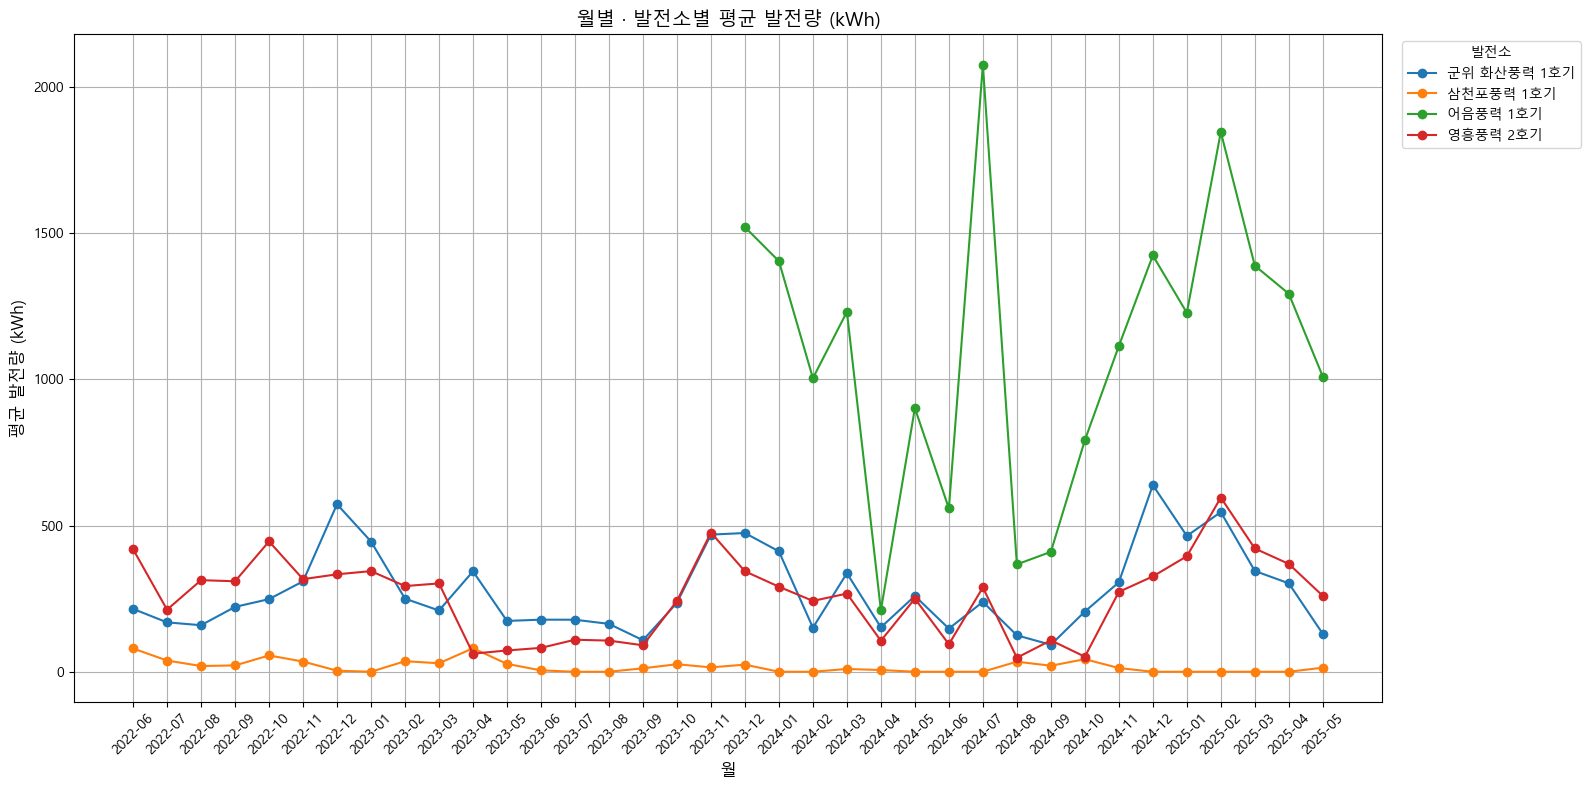

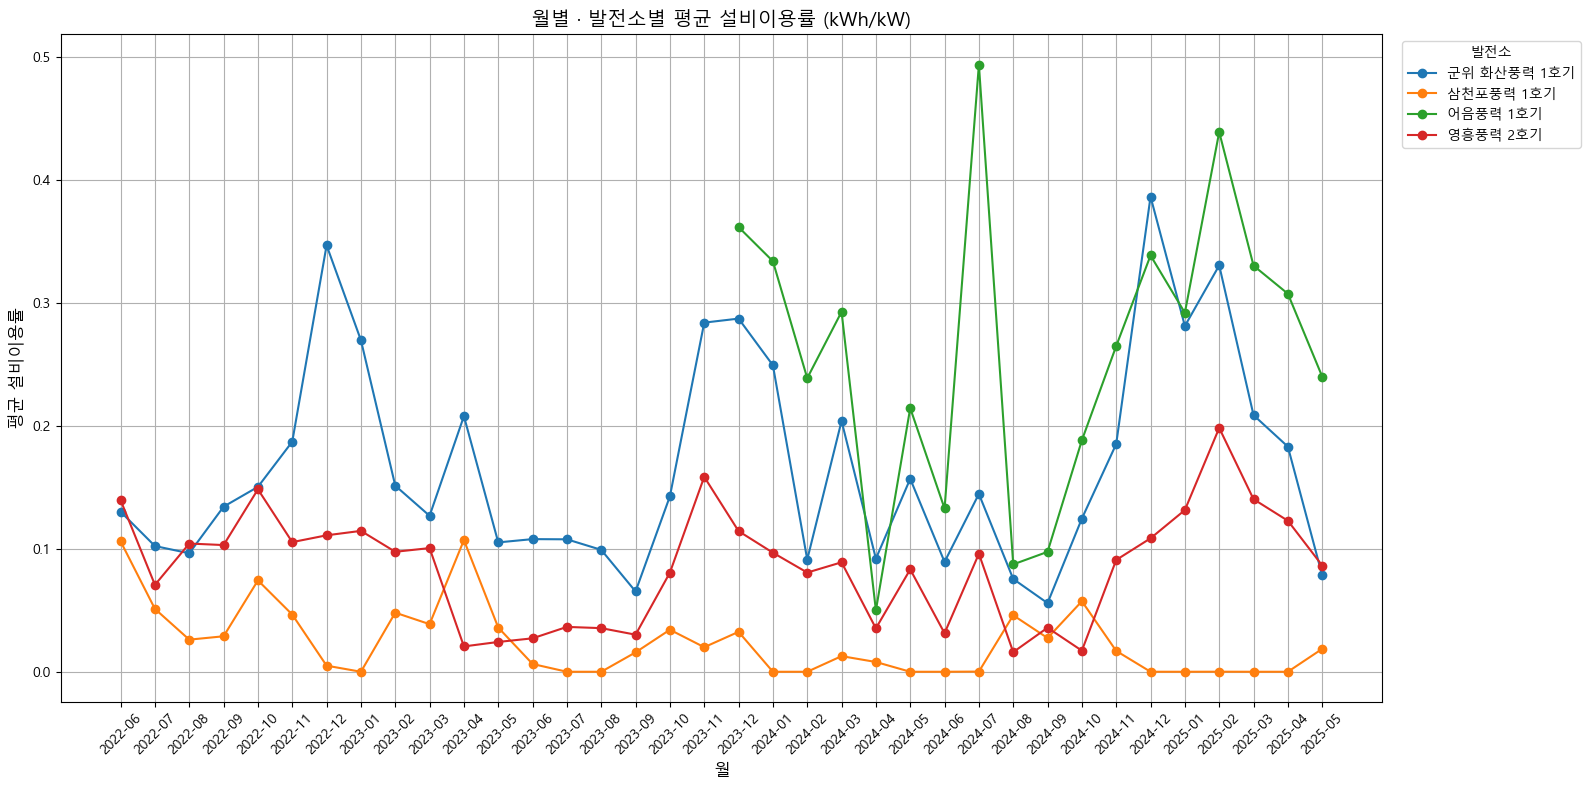

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

# ✅ 1. CSV 파일 불러오기
file_path = '한국남동발전_시간대별_풍력_발전실적_최종.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')

# ✅ 2. 날짜 변환 및 월 컬럼 생성
df['일자'] = pd.to_datetime(df['일자'])
df['월'] = df['일자'].dt.to_period('M')

# ✅ 3. 발전소 컬럼 생성
df['발전소'] = df['발전구분'].astype(str) + ' ' + df['호기'].astype(str) + '호기'

# ✅ 4. 발전량 기반 월별 평균
monthly_avg = df.groupby(['월', '발전소'])['발전량(kWh)'].mean().reset_index()

# ✅ 5. 설비이용률 계산 (kWh / (MW * 1000))
df['설비이용률'] = df['발전량(kWh)'] / (df['설비용량(MW)'] * 1000)
monthly_util = df.groupby(['월', '발전소'])['설비이용률'].mean().reset_index()

# ✅ 6. 그래프 1: 월별 · 발전소별 평균 발전량
plt.figure(figsize=(16, 8))
for name, group in monthly_avg.groupby('발전소'):
    plt.plot(group['월'].astype(str), group['발전량(kWh)'], marker='o', label=name)

plt.title('월별 · 발전소별 평균 발전량 (kWh)', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균 발전량 (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ✅ 7. 그래프 2: 월별 · 발전소별 평균 설비이용률
plt.figure(figsize=(16, 8))
for name, group in monthly_util.groupby('발전소'):
    plt.plot(group['월'].astype(str), group['설비이용률'], marker='o', label=name)

plt.title('월별 · 발전소별 평균 설비이용률 (kWh/kW)', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균 설비이용률', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 기상청 API 데이터 불러오기

In [28]:
import requests
import ssl
from requests.adapters import HTTPAdapter
from urllib3.poolmanager import PoolManager

class SSLAdapter(HTTPAdapter):
    def __init__(self, ssl_context=None, **kwargs):
        self.ssl_context = ssl_context
        super().__init__(**kwargs)

    def init_poolmanager(self, *args, **kwargs):
        kwargs['ssl_context'] = self.ssl_context
        return super().init_poolmanager(*args, **kwargs)

# TLS 1.2 이상의 context 강제 설정
context = ssl.create_default_context()
context.set_ciphers('DEFAULT@SECLEVEL=1')  # 낮은 보안 레벨 허용할 경우

session = requests.Session()
session.mount('https://', SSLAdapter(context))

# 요청 보내기
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
params = {
    "serviceKey": "zJLFmDMckurk+au32kOHTxsrU5gG2NAadNE68xYaBW8PBJtdXN7F4QEpuW6f68GL0qLcMQsmgyPHxbOs43NCBA==",
    "numOfRows": "1000",
    "pageNo": "1",
    "dataType": "JSON",
    "base_date": "20250627",
    "base_time": "0500",
    "nx": "55",
    "ny": "127"
}
response = session.get(url, params=params)
print(response.json())


{'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL_SERVICE'}, 'body': {'dataType': 'JSON', 'items': {'item': [{'baseDate': '20250627', 'baseTime': '0500', 'category': 'TMP', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '20', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'UUU', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.1', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'VVV', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.4', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'VEC', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '194', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'WSD', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.4', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'SKY', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '4', 

In [29]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------------------------------------------------
# 1. API 호출을 위한 기본 설정
# ----------------------------------------------------------------------

now = datetime.now()
if now.hour < 5:
    base_date = (now - timedelta(days=1)).strftime('%Y%m%d')
else:
    base_date = now.strftime('%Y%m%d')

url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
serviceKey = "zJLFmDMckurk+au32kOHTxsrU5gG2NAadNE68xYaBW8PBJtdXN7F4QEpuW6f68GL0qLcMQsmgyPHxbOs43NCBA=="  # 본인의 서비스 키로 변경하세요

# ----------------------------------------------------------------------
# 2. 반복문을 사용해 모든 페이지의 데이터 수집
# ----------------------------------------------------------------------

all_items = []
page_no = 1
num_of_rows = 5000

print("데이터 수집을 시작합니다...")

while True:
    print(f" - {page_no} 페이지 데이터 요청 중...")
    
    params = {
        'serviceKey': serviceKey,
        'numOfRows': str(num_of_rows),
        'pageNo': str(page_no),
        'dataType': 'JSON',
        'base_date': base_date,
        'base_time': '0500',
        'nx': '55',
        'ny': '127'
    }

    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()

        data = response.json()
        
        if data['response']['header']['resultCode'] != '00':
            print(f"❌ API 에러 응답: {data['response']['header']['resultMsg']}")
            break

        items = data['response']['body']['items'].get('item', [])
        all_items.extend(items)

        if len(items) < num_of_rows:
            print(f"마지막 페이지({page_no})입니다. 데이터 수집을 완료합니다.")
            break

        page_no += 1

    except requests.exceptions.RequestException as e:
        print(f"❌ 네트워크 또는 HTTP 에러 발생: {e}")
        break
    except requests.exceptions.JSONDecodeError:
        print("❌ JSON 파싱 에러: 서버 응답이 유효한 JSON이 아닙니다.")
        print(f"--- 서버 실제 응답 (Status: {response.status_code}) ---")
        print(response.text)
        break
    except KeyError:
        print("❌ 데이터 구조 에러: 응답 받은 JSON의 키가 예상과 다릅니다.")
        print("--- 서버 실제 응답 ---")
        print(data)
        break

# ----------------------------------------------------------------------
# 3. 수집된 모든 데이터를 표(DataFrame)로 변환 및 출력
# ----------------------------------------------------------------------

if all_items:
    df = pd.DataFrame(all_items)
    df.drop_duplicates(inplace=True)
    
    print(f"\n총 {len(df)}개의 유니크한 데이터를 수집했습니다. 표로 변환합니다.")

    # fcstDate와 fcstTime을 인덱스로 지정하여 pivot_table 생성
    pivot_df = df.pivot_table(
        index=['fcstDate', 'fcstTime'], 
        columns='category', 
        values='fcstValue', 
        aggfunc='first'
    ).reset_index()

    desired_order = ['fcstDate', 'fcstTime', 'TMP', 'SKY', 'PTY', 'POP', 'PCP', 'REH', 'WSD', 'SNO']
    current_columns = [col for col in desired_order if col in pivot_df.columns]
    remaining_columns = [col for col in pivot_df.columns if col not in current_columns]
    pivot_df = pivot_df[current_columns + remaining_columns]

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)

    print("\n--- 기상청 단기예보 (전체 데이터, 날짜 포함) ---")
    print(pivot_df)
else:
    print("\n수집된 데이터가 없습니다. 서비스 키 또는 요청 파라미터를 확인해주세요.")


데이터 수집을 시작합니다...
 - 1 페이지 데이터 요청 중...
❌ 네트워크 또는 HTTP 에러 발생: HTTPConnectionPool(host='apis.data.go.kr', port=80): Read timed out. (read timeout=10)

수집된 데이터가 없습니다. 서비스 키 또는 요청 파라미터를 확인해주세요.


In [30]:
pivot_df

category,일자,시간,기온(°C),하늘상태,강수량(mm),습도(%),풍속(m/s),적설(cm),풍향(16방위)
0,2025-06-27,6,20,4,0.0,95,0.4,0.0,194
1,2025-06-27,7,20,4,0.0,90,0.8,0.0,270
2,2025-06-27,8,21,4,0.0,90,0.8,0.0,23
3,2025-06-27,9,22,4,0.0,85,1.5,0.0,16
4,2025-06-27,10,23,4,0.0,85,2.4,0.0,57
5,2025-06-27,11,23,4,0.0,85,2.9,0.0,59
6,2025-06-27,12,24,4,0.0,85,3.4,0.0,58
7,2025-06-27,13,25,4,0.0,80,2.3,0.0,70
8,2025-06-27,14,25,4,0.0,80,3.3,0.0,83
9,2025-06-27,15,26,4,0.0,80,2.9,0.0,86


<span style="font-size:12px">

## 🌦 기상청 예보 데이터 컬럼 설명

| 컬럼명 | 의미 | 단위 또는 값 |
|--------|------|---------------|
| `fcstDate` | 예보 날짜 | 예: `20250627` → 2025년 6월 27일 |
| `fcstTime` | 예보 시각 | 예: `0600` → 오전 6시 |
| `TMP` | 기온 | ℃ (섭씨 온도) |
| `SKY` | 하늘 상태 | 1: 맑음, 3: 구름 많음, 4: 흐림 |
| `PTY` | 강수 형태 | 0: 없음, 1: 비, 2: 비/눈, 3: 눈, 4: 소나기 등 |
| `POP` | 강수 확률 | % |
| `PCP` | 1시간 강수량 | mm 또는 `"강수없음"` |
| `REH` | 습도 | % |
| `WSD` | 풍속 | m/s (미터/초) |
| `SNO` | 1시간 적설량 | cm 또는 `"적설없음"` |
| `TMN` | 일 최저기온 | ℃ (해당 날짜 전체의 최저 예상 기온) |
| `TMX` | 일 최고기온 | ℃ (해당 날짜 전체의 최고 예상 기온) |
| `UUU` | 동서 바람 성분 | m/s (음수: 서풍, 양수: 동풍) |
| `VVV` | 남북 바람 성분 | m/s (음수: 북풍, 양수: 남풍) |
| `VEC` | 풍향 | 도 (°), 0: 북, 90: 동, 180: 남, 270: 서 |
| `WAV` | 파고 (해상용) | m (육상 예보에서는 -999로 무효 값 처리됨) |

---

## 💡 추가 설명

- `UUU`, `VVV`는 바람의 벡터 성분입니다.  
  → 풍속(`WSD`)과 풍향(`VEC`)으로부터 계산 가능  
  → `풍속^2 = UUU^2 + VVV^2`, `풍향 = atan2(UUU, VVV)`

- `TMX`, `TMN`은 하루에 한 번만 나타나며, 그 날 전체를 대표하는 예보입니다.

- `PCP`, `SNO`는 `"강수없음"`, `"적설없음"`처럼 문자열이 포함되어 있어 수치 분석 시 처리 필요합니다.

- `WAV`는 해양 예보 전용 항목이며, 육상에서는 대부분 `-999`로 나타나며 무시해도 무방합니다.


### 기상청 API 데이터 전처리

In [31]:
pivot_df.head(5)

category,일자,시간,기온(°C),하늘상태,강수량(mm),습도(%),풍속(m/s),적설(cm),풍향(16방위)
0,2025-06-27,6,20,4,0.0,95,0.4,0.0,194
1,2025-06-27,7,20,4,0.0,90,0.8,0.0,270
2,2025-06-27,8,21,4,0.0,90,0.8,0.0,23
3,2025-06-27,9,22,4,0.0,85,1.5,0.0,16
4,2025-06-27,10,23,4,0.0,85,2.4,0.0,57


In [32]:
# 제거할 컬럼 리스트
drop_columns = ['TMN', 'TMX', 'WAV', 'UUU', 'VVV', 'PTY', 'POP']

# 컬럼이 존재할 경우에만 삭제하도록 처리
pivot_df = pivot_df.drop(columns=[col for col in drop_columns if col in pivot_df.columns])


In [33]:
# 컬럼명 매핑 딕셔너리 (SKY 추가됨)
rename_dict = {
    'fcstDate': '일자',
    'fcstTime': '시간',
    'TMP': '기온(°C)',
    'PCP': '강수량(mm)',
    'REH': '습도(%)',
    'WSD': '풍속(m/s)',
    'SNO': '적설(cm)',
    'VEC': '풍향(16방위)',
    'SKY': '하늘상태',
}

# 컬럼명 변경
pivot_df = pivot_df.rename(columns=rename_dict)



In [34]:
# 일자: 문자열 '20250627' → '2025-06-27'로 변환
pivot_df['일자'] = pd.to_datetime(pivot_df['일자'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

# 시간: 문자열 '0600' → 정수 6
pivot_df['시간'] = pivot_df['시간'].astype(str).str[:2].astype(int)


ValueError: time data "2025-06-27" doesn't match format "%Y%m%d", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
import re

def clean_precip(val):
    # NaN이면 그대로 반환
    if pd.isna(val):
        return val
    val = str(val)
    
    # 강수없음, 적설없음 → 0
    if '없음' in val:
        return 0.0
    
    # 1mm 미만 → 관례적으로 0.5로 처리하거나 0.0으로 처리 가능
    if '미만' in val:
        return 0.5  # 또는 0.0으로 바꿔도 됨
    
    # 숫자만 추출 (예: '2.5mm' → 2.5)
    numeric_part = re.findall(r"[\d.]+", val)
    return float(numeric_part[0]) if numeric_part else 0.0

# 적용
pivot_df['강수량(mm)'] = pivot_df['강수량(mm)'].apply(clean_precip)
pivot_df['적설(cm)'] = pivot_df['적설(cm)'].apply(clean_precip)


In [ ]:
pivot_df.head(5)

category,일자,시간,기온(°C),하늘상태,강수량(mm),습도(%),풍속(m/s),적설(cm),풍향(16방위)
0,2025-06-27,6,20,4,0.0,95,0.4,0.0,194
1,2025-06-27,7,20,4,0.0,90,0.8,0.0,270
2,2025-06-27,8,21,4,0.0,90,0.8,0.0,23
3,2025-06-27,9,22,4,0.0,85,1.5,0.0,16
4,2025-06-27,10,23,4,0.0,85,2.4,0.0,57


### 기상청 csv 데이터 전처리

In [35]:
df_weather = pd.read_csv('weather_merged.csv')
df_weather.head(5)

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일사(MJ/m2),적설(cm),전운량(10분위)
0,112,인천,2022-06-01 1:00,18.1,NaN,4.2,160.0,47.0,998.8,NaN,NaN,7.0
1,112,인천,2022-06-01 2:00,17.8,NaN,3.0,160.0,47.0,999.3,NaN,NaN,1.0
2,112,인천,2022-06-01 3:00,17.8,NaN,3.3,180.0,46.0,999.3,NaN,NaN,7.0
3,112,인천,2022-06-01 4:00,18.0,NaN,1.2,50.0,53.0,1001.2,NaN,NaN,5.0
4,112,인천,2022-06-01 5:00,16.7,NaN,1.5,70.0,55.0,1000.4,NaN,NaN,4.0


In [36]:
# 제거할 컬럼 리스트
drop_columns = ['지점', '현지기압(hPa)', '일사(MJ/m2)']

# 컬럼이 존재할 경우에만 삭제하도록 처리
df_weather = df_weather.drop(columns=[col for col in drop_columns if col in df_weather.columns])
df_weather.head(5)

,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),전운량(10분위)
0,인천,2022-06-01 1:00,18.1,NaN,4.2,160.0,47.0,NaN,7.0
1,인천,2022-06-01 2:00,17.8,NaN,3.0,160.0,47.0,NaN,1.0
2,인천,2022-06-01 3:00,17.8,NaN,3.3,180.0,46.0,NaN,7.0
3,인천,2022-06-01 4:00,18.0,NaN,1.2,50.0,53.0,NaN,5.0
4,인천,2022-06-01 5:00,16.7,NaN,1.5,70.0,55.0,NaN,4.0


In [37]:
# 일시 컬럼을 datetime 형식으로 변환
df_weather['일시'] = pd.to_datetime(df_weather['일시'])

# 일자 컬럼 생성 (형식: '2022-06-01')
df_weather['일자'] = df_weather['일시'].dt.strftime('%Y-%m-%d')

# 시간 컬럼 생성 (형식: 1, 2, 3, ..., 24)
df_weather['시간'] = df_weather['일시'].dt.hour

# 필요 시 기존 '일시' 컬럼 제거
df_weather = df_weather.drop(columns=['일시'])
df_weather.head(5)

,지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),전운량(10분위),일자,시간
0,인천,18.1,NaN,4.2,160.0,47.0,NaN,7.0,2022-06-01,1
1,인천,17.8,NaN,3.0,160.0,47.0,NaN,1.0,2022-06-01,2
2,인천,17.8,NaN,3.3,180.0,46.0,NaN,7.0,2022-06-01,3
3,인천,18.0,NaN,1.2,50.0,53.0,NaN,5.0,2022-06-01,4
4,인천,16.7,NaN,1.5,70.0,55.0,NaN,4.0,2022-06-01,5


In [38]:
# 현재 컬럼들 확인
cols = df_weather.columns.tolist()

# 기준이 되는 컬럼 이름 (예: '지점' 또는 '지점명')
key_col = '지점명'  # 또는 '지점'으로 바꿔도 됨

# '지점명' 다음에 '일자', '시간'을 삽입
if key_col in cols:
    idx = cols.index(key_col)
    # 기존에 '일자', '시간'이 이미 들어있다면 먼저 제거
    for c in ['일자', '시간']:
        if c in cols:
            cols.remove(c)
    # 삽입
    new_order = cols[:idx+1] + ['일자', '시간'] + cols[idx+1:]
    df_weather = df_weather[new_order]
else:
    print(f"⚠️ 컬럼 '{key_col}'이 존재하지 않습니다.")

df_weather.head(5)

,지점명,일자,시간,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),전운량(10분위)
0,인천,2022-06-01,1,18.1,NaN,4.2,160.0,47.0,NaN,7.0
1,인천,2022-06-01,2,17.8,NaN,3.0,160.0,47.0,NaN,1.0
2,인천,2022-06-01,3,17.8,NaN,3.3,180.0,46.0,NaN,7.0
3,인천,2022-06-01,4,18.0,NaN,1.2,50.0,53.0,NaN,5.0
4,인천,2022-06-01,5,16.7,NaN,1.5,70.0,55.0,NaN,4.0


In [39]:
def map_cloud_to_sky(cloud):
    if pd.isna(cloud):
        return None
    try:
        c = float(cloud)
    except:
        return None
    if c <= 2:
        return 1
    elif c <= 7:
        return 3
    else:
        return 4
    
df_weather = df_weather.rename(columns={'전운량(10분위)': '하늘상태'})

# 전운량 컬럼이 '전운량(10분위)'라는 이름일 경우
df_weather['하늘상태'] = df_weather['하늘상태'].apply(map_cloud_to_sky)


df_weather.head(5)

,지점명,일자,시간,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),하늘상태
0,인천,2022-06-01,1,18.1,NaN,4.2,160.0,47.0,NaN,3.0
1,인천,2022-06-01,2,17.8,NaN,3.0,160.0,47.0,NaN,1.0
2,인천,2022-06-01,3,17.8,NaN,3.3,180.0,46.0,NaN,3.0
3,인천,2022-06-01,4,18.0,NaN,1.2,50.0,53.0,NaN,3.0
4,인천,2022-06-01,5,16.7,NaN,1.5,70.0,55.0,NaN,3.0


In [40]:
df_weather['강수량(mm)'] = df_weather['강수량(mm)'].fillna(0)
df_weather['적설(cm)'] = df_weather['적설(cm)'].fillna(0)


### 발전량 데이터 + 기상청 데이터

In [47]:
# 3. 발전소 → 지점명 매핑
plant_to_location = {
    '삼천포풍력': '통영',
    '영흥풍력': '인천',
    '군위 화산풍력': '영천',
    '어음풍력': '제주'
}

# '일자' 컬럼이 문자열(예: '2025-05-31')인 경우
df_energy = df_energy[df_energy['일자'] != '2025-05-31']

# 4. 지점명 컬럼 추가
df_energy['지점명'] = df_energy['발전구분'].map(plant_to_location)

df_energy['지점명'] = df_energy['지점명'].astype(str).str.strip()
df_weather['지점명'] = df_weather['지점명'].astype(str).str.strip()

# 5. 날짜 형식 맞추기 (둘 다 'YYYY-MM-DD' 형태여야 병합됨)
df_energy['일자'] = pd.to_datetime(df_energy['일자']).dt.strftime('%Y-%m-%d')
df_weather['일자'] = pd.to_datetime(df_weather['일자']).dt.strftime('%Y-%m-%d')

df_energy['시간'] = df_energy['시간'].astype(int)
df_weather['시간'] = df_weather['시간'].astype(int)

# 6. 병합: 지점명 + 일자 + 시간 기준
df_merged = pd.merge(df_energy, df_weather, on=['지점명', '일자', '시간'], how='left')

# 7. 결과 확인 (앞부분 출력)
print(df_merged.head())

# 8. 결과 저장
#df_merged.to_csv('병합된_발전량_날씨데이터.csv', index=False, encoding='utf-8-sig')


    발전구분  호기          일자  시간  발전량(kWh)  설비용량(MW)  연식(년) 지점명  기온(°C)  강수량(mm)  풍속(m/s)  풍향(16방위)  습도(%)  적설(cm)  하늘상태
0  삼천포풍력   1  2025-05-30   1       0.0      0.75    7.1  통영    15.5      0.0      1.6     110.0   80.0     0.0   1.0
1  삼천포풍력   1  2025-05-30   2       0.0      0.75    7.1  통영    14.8      0.0      1.1      70.0   83.0     0.0   1.0
2  삼천포풍력   1  2025-05-30   3       0.0      0.75    7.1  통영    14.7      0.0      1.1      20.0   90.0     0.0   1.0
3  삼천포풍력   1  2025-05-30   4       0.0      0.75    7.1  통영    14.3      0.0      1.3      50.0   89.0     0.0   1.0
4  삼천포풍력   1  2025-05-30   5       0.0      0.75    7.1  통영    14.4      0.0      1.5      50.0   93.0     0.0   1.0


In [48]:
df_merged.head()

,발전구분,호기,일자,시간,발전량(kWh),설비용량(MW),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),적설(cm),하늘상태
0,삼천포풍력,1,2025-05-30,1,0.0,0.75,7.1,통영,15.5,0.0,1.6,110.0,80.0,0.0,1.0
1,삼천포풍력,1,2025-05-30,2,0.0,0.75,7.1,통영,14.8,0.0,1.1,70.0,83.0,0.0,1.0
2,삼천포풍력,1,2025-05-30,3,0.0,0.75,7.1,통영,14.7,0.0,1.1,20.0,90.0,0.0,1.0
3,삼천포풍력,1,2025-05-30,4,0.0,0.75,7.1,통영,14.3,0.0,1.3,50.0,89.0,0.0,1.0
4,삼천포풍력,1,2025-05-30,5,0.0,0.75,7.1,통영,14.4,0.0,1.5,50.0,93.0,0.0,1.0


### 통합 데이터셋 EDA

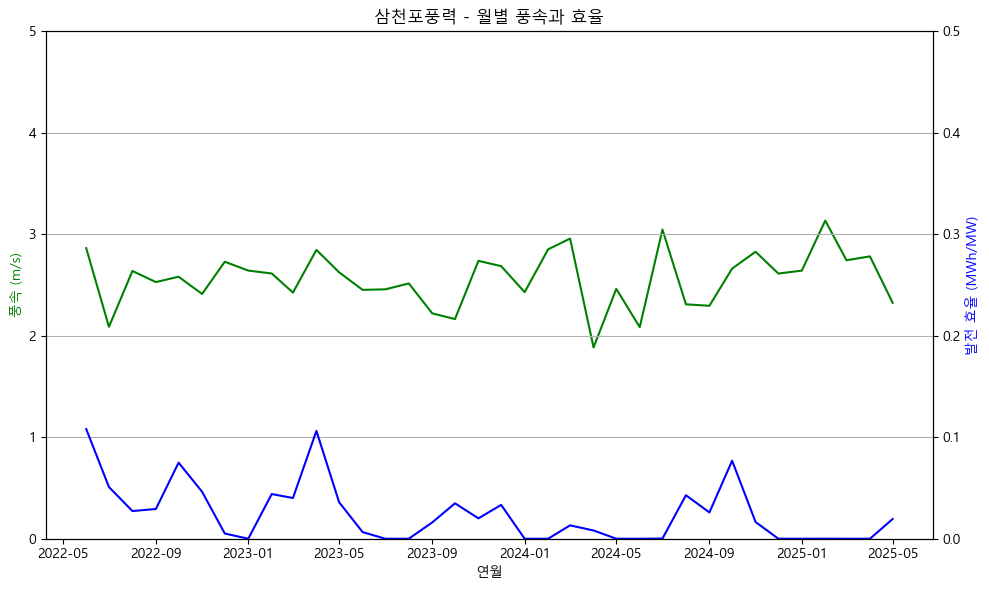

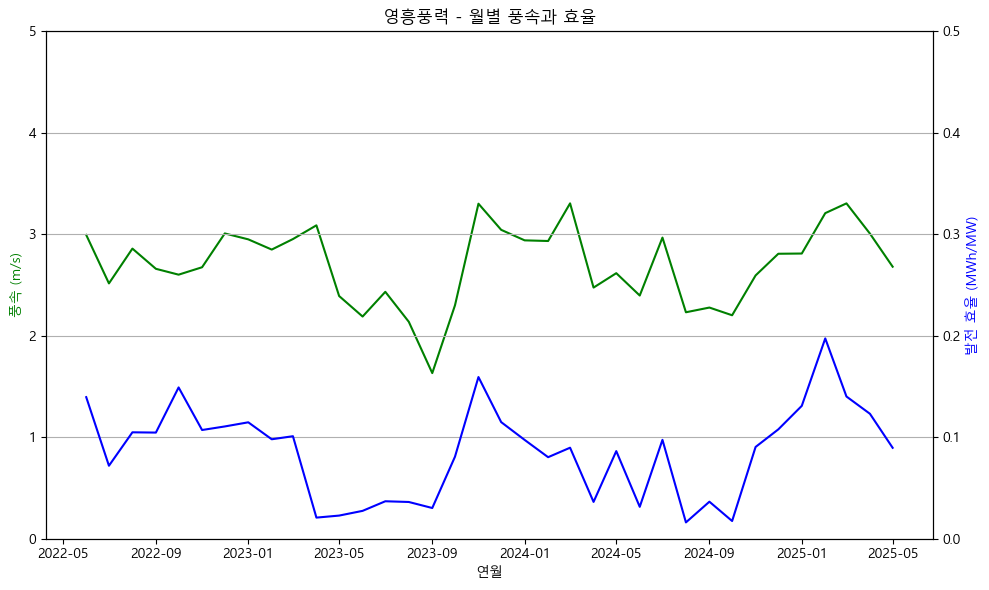

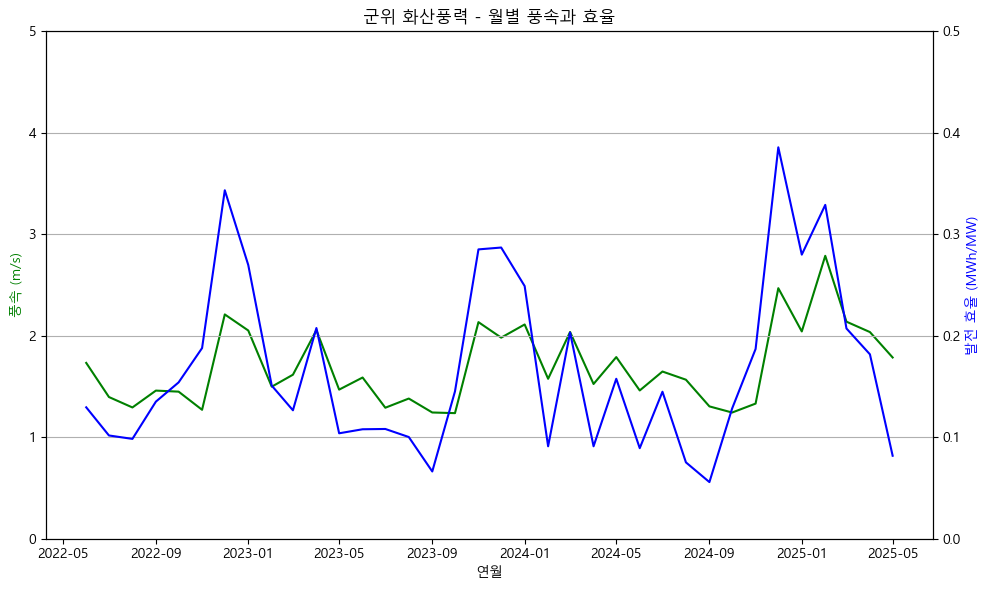

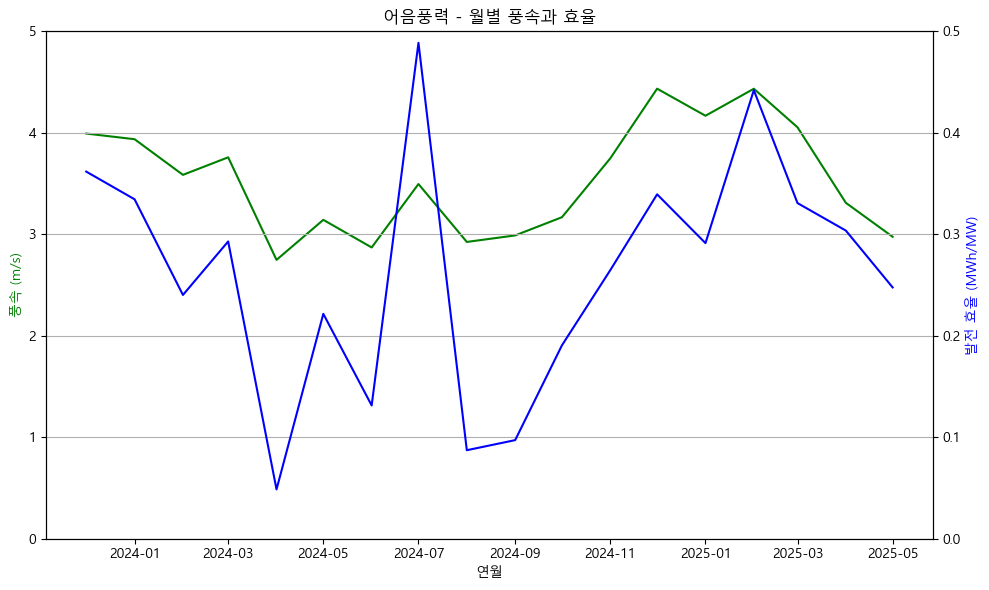

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 연월 처리
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')
df_merged['연월'] = df_merged['일자'].dt.to_period('M').astype(str)
df_merged['효율'] = df_merged['발전량(kWh)'] / df_merged['설비용량(MW)'] / 1000  # ⚠️ 1000으로 나눔
df_merged = df_merged.dropna(subset=['효율', '풍속(m/s)', '연월', '발전구분'])

# 고정된 y축 범위 설정
풍속_min, 풍속_max = 0, 5
효율_min, 효율_max = 0, 0.5  # ⚠️ 효율 y축도 0~5로 조정

# 발전소 목록
plants = df_merged['발전구분'].unique()

# 3. 발전소별 그래프
for plant in plants:
    sub = df_merged[df_merged['발전구분'] == plant]
    if sub.empty:
        continue

    monthly = sub.groupby('연월')[['풍속(m/s)', '효율']].mean().reset_index()
    monthly['연월'] = pd.to_datetime(monthly['연월'])
    monthly = monthly.sort_values('연월')

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax2 = ax1.twinx()

    ax1.plot(monthly['연월'], monthly['풍속(m/s)'], 'g-', label='풍속 (m/s)')
    ax2.plot(monthly['연월'], monthly['효율'], 'b-', label='발전 효율 (MWh/MW)')

    ax1.set_xlabel('연월')
    ax1.set_ylabel('풍속 (m/s)', color='g')
    ax2.set_ylabel('발전 효율 (MWh/MW)', color='b')  # 단위도 반영

    ax1.set_ylim(풍속_min, 풍속_max)
    ax2.set_ylim(효율_min, 효율_max)

    plt.title(f'{plant} - 월별 풍속과 효율')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
